# Node2vec Implementation

This algorithm contains two steps:
1. Generate sequences from graph by using random walk
2. Use word2vec model to train embedding matrix from sequences

In [1]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse import *
import tensorflow as tf
from sklearn.manifold import TSNE
from tqdm import tqdm
%matplotlib inline

In [2]:
# prepare the graph
row  = np.array([0, 3, 1, 0])
col  = np.array([0, 3, 1, 2])
data = np.array([4, 5, 7, 9])
A = coo_matrix((data, (row, col)), shape=(4, 4)).tocsr() # store it as row matrix for better performance

## Random Walk by using search bias alpha
Let $t$ be the previous node, $v$ be the current node, so the $\pi_{vx}$ for each $x$ node in the graph is defined as below:
$$\pi_{vx} = \alpha_{pq}(t,x)w_{vx}$$
$$\alpha_{pq}(t,x) = \left\{\begin{array}[ll]\\
                \frac{1}{p} & \mbox{if}~d_{tx} = 0\\
                1 & \mbox{if}~d_{tx} = 1\\
                \frac{1}{q} & \mbox{if}~d_{tx} = 2
           \end{array}\right.$$

In [3]:
def alpha(t, x, p, q, data_graph):
    """
    param:
    
    Input:
        @t: int, node index
        @x: int, node index
        @p: float, return factor
        @q: float, go futher factor
        @data_graph: matrix representation for graph
        
    Output:
        @rtype: float
    """
    if t == x:
        return 1.0/p
    elif data_graph[t, x] != 0:
        return 1
    else:
        return 1.0/q

def random_walk(start, p, q, sequence_length, data_graph):
    sequence = []
    for step in xrange(sequence_length):
        if step == 0:
            sequence.append(start)
        elif step == 1:
            current = data_graph[sequence[step-1],:].toarray().flatten()
            if sum(current) != 0:
                sequence.append(np.random.choice(range(data_graph.shape[1]), p=current/np.linalg.norm(current, ord=1)))
            else:
                sequence.append(sequence[step-1])
        else:
            current = data_graph[sequence[step-1],:].toarray().flatten()
            if sum(current) != 0:
                past = sequence[step-2]
                pi_list = []
                for i in xrange(data_graph.shape[1]):
                    if current[i] != 0:
                        pi_list.append(alpha(past, i, p, q, data_graph)*current[i])
                    else:
                        pi_list.append(0)
                sequence.append(np.random.choice(range(data_graph.shape[1]), p=pi_list/np.linalg.norm(pi_list, ord=1)))
            else:
                sequence.append(sequence[step-1])
    return sequence

## Define word2vec model

In [4]:
# define neural net as word2vec
class Node2Vec(object):
    """docstring for Node2Vec"""
    def __init__(self, num_nodes, emb_size, lr, batch_size, context_size):
        self.num_nodes = num_nodes
        self.emb_size = emb_size
        self.lr = lr
        self.batch_size = batch_size
        self.context_size = context_size

    def build(self):
        # Parameters to learn
#         node_embeddings = tf.Variable(tf.random_uniform([num_nodes, embedding_size], -1.0, 1.0))
#         softmax_weights = tf.Variable(tf.truncated_normal([num_nodes, embedding_size],stddev=1.0 / math.sqrt(embedding_size)))
#         softmax_biases = tf.Variable(tf.zeros([num_nodes]))

#         # Input data and re-orgenize size.
#         with tf.name_scope("context_node") as scope:
#             #context nodes to each input node in the batch (e.g [[1,2],[4,6],[5,7]] where batch_size = 3,context_size=3)
#             train_context_node= tf.placeholder(tf.int32, shape=[batch_size,context_size],name="context_node")
#             #orgenize prediction labels (skip-gram model predicts context nodes (i.e labels) given a input node)
#             #i.e make [[1,2,4,6,5,7]] given context above. The redundant dimention is just for restriction on tensorflow API.
#             train_context_node_flat=tf.reshape(train_context_node,[-1,1])
#         with tf.name_scope("input_node") as scope:
#             #batch input node to the network(e.g [2,1,3] where batch_size = 3)
#             train_input_node= tf.placeholder(tf.int32, shape=[batch_size],name="input_node")
#             #orgenize input as flat. i.e we want to make [2,2,2,1,1,1,3,3,3] given the  input nodes above
#             input_ones=tf.ones_like(train_context_node)
#             train_input_node_flat=tf.reshape(tf.mul(input_ones,tf.reshape(train_input_node,[-1,1])),[-1])

#         # Model.
#         with tf.name_scope("loss") as scope:
#             # Look up embeddings for words.
#             node_embed = tf.nn.embedding_lookup(node_embeddings, train_input_node_flat)
#             # Compute the softmax loss, using a sample of the negative labels each time.
#             loss_node2vec = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights,softmax_biases,node_embed,train_context_node_flat, num_sampled, num_nodes))
#             loss_node2vec_summary = tf.scalar_summary("loss_node2vec", loss_node2vec)
        self.train_context_node = tf.placeholder(tf.int32, shape=[self.batch_size, self.context_size]) # (batch_size, context_size)
        self.train_input_node = tf.placeholder(tf.int32, shape=[self.batch_size, 1])
        labels = tf.one_hot(self.train_input_node, self.num_nodes) # (batch_size, numb_nodes)
        self.embedding_matrix = tf.Variable(tf.random_uniform([self.num_nodes, self.emb_size], -1.0, 1.0)) 
        graph_emb = tf.nn.embedding_lookup(self.embedding_matrix, self.train_context_node)# (batch_size, context_size, emb_size)
        graph_emb = tf.reduce_sum(graph_emb, 1) # (batch_size, emb_size)
        graph_emb = tf.nn.tanh(graph_emb)
        W = tf.Variable(tf.truncated_normal([self.emb_size, self.num_nodes],stddev=1.0 / np.sqrt(self.emb_size)))
        b = tf.Variable(tf.zeros([self.num_nodes]))
        output = tf.nn.xw_plus_b(graph_emb, W, b) # (batch_size, numb_nodes)
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(output, labels))
        # loss_node2vec_summary = tf.scalar_summary("loss_node2vec", loss)
        self.update_loss = tf.train.AdamOptimizer(learning_rate = self.lr).minimize(self.loss)

## Training process

In [5]:
# read edge data from txt file and store it as csr_matrix
with open("graph.txt") as f:
    edges = f.readlines()
rows = []
cols = []
data = []
biggest_node_index = 0
for edge in edges:
    row, col = edge.strip().split()
    rows.append(int(row)-1)
    rows.append(int(col)-1)
    cols.append(int(col)-1)
    cols.append(int(row)-1)
    data += [1,1]
    biggest_node_index = max([max([int(row), int(col)]), biggest_node_index])
data_graph = coo_matrix((data, (rows, cols)), shape=(biggest_node_index, biggest_node_index)).tocsr()

In [6]:
# set some hyperparameter
p = 0.5
q = 2
num_text = 1000
sequence_length = 32
num_nodes = data_graph.shape[0]
emb_size = 200
lr = 0.001
batch_size = None
context_size = 16
num_epoch = 10
num_sampled = 64

### 1. Sample the walk sequence from random walk

In [7]:
# Sampling
corpus = []
for i in tqdm(xrange(num_text)):
    start = np.random.choice(range(num_nodes))
    corpus.append(random_walk(start, p, q, sequence_length, data_graph))

100%|██████████| 1000/1000 [00:08<00:00, 122.38it/s]


### 2. Build the neural net and train it

In [8]:
# training the neural net
net = Node2Vec(num_nodes, emb_size, lr, batch_size, context_size)
net.build()

In [19]:
init = tf.initialize_all_variables()
# merged = tf.merge_all_summaries()
with tf.Session() as sess:
    log_dir = "./log1"
#     writer = tf.train.SummaryWriter(log_dir, sess.graph)
    sess.run(init)
    t = 0
    for epoch in xrange(num_epoch):
        for i in xrange(num_text):
            current_seq = corpus[i]
            labels = np.array([current_seq[j:j+1] for j in xrange(sequence_length - context_size)])
            inputs = np.array([current_seq[j+1:j+1+context_size] for j in xrange(sequence_length - context_size)])
            feed_dict = {net.train_context_node: inputs, net.train_input_node: labels}
            _, loss = sess.run([net.update_loss, net.loss], feed_dict=feed_dict)
        #         writer.add_summary(summary,i)
            t += 1
            if t % 1000 == 0:
                print(loss)
    # Get the final result
    Final_emb = sess.run(net.embedding_matrix)

2.46532
2.37562
2.35806
2.35373
2.35121
2.35077
2.34813
2.33778
2.31822
2.29154


### 3. Visualization

In [22]:
# Use t-sne to see the node
low_manifest = TSNE().fit_transform(Final_emb)

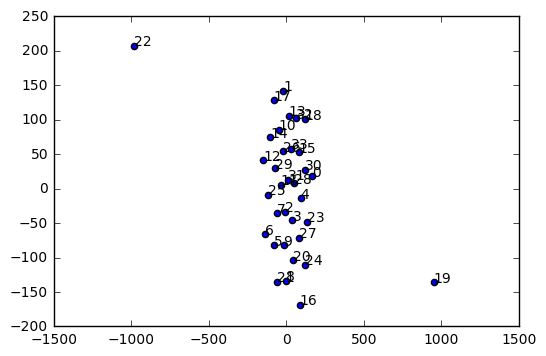

In [23]:
for i in xrange(len(low_manifest)):
    plt.scatter(low_manifest[i][0], low_manifest[i][1])
    plt.text(low_manifest[i][0], low_manifest[i][1], str(i))
plt.show()

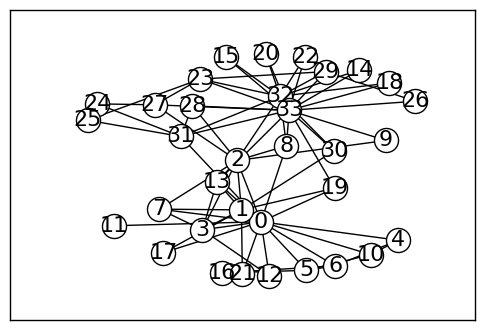

In [12]:
# Visualize the Graph
G = nx.Graph(data_graph.toarray())
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color="w")
nx.draw_networkx_edges(G, pos, width=1)
nx.draw_networkx_labels(G, pos ,font_size=16, font_color="black")

plt.xticks([])
plt.yticks([])
plt.show()